In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [6]:
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [7]:
# Print all of the classes mapped to the Base
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [9]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Using the inspector to print the column names within the 'measurement' table and its types
print("Measurement table column details :")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


Measurement table column details :
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector to print the column names within the 'station' table and its types
print("Station table column details :")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

Station table column details :
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
conn = engine.connect()
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
# Query All Records in the the Database
latest_date = session.query(func.max(Measurement.date)).first()[0]
latest_date = pd.to_datetime(latest_date)
latest_date


Timestamp('2017-08-23 00:00:00')

In [15]:
#get the column details for measurement table and see what rows are present using read_sql
measurement_pd = pd.read_sql("SELECT * FROM measurement order by date desc", conn)
measurement_pd['date2'] = pd.to_datetime(measurement_pd['date'])
measurement_pd.info()
measurement_pd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       19550 non-null  int64         
 1   station  19550 non-null  object        
 2   date     19550 non-null  object        
 3   prcp     18103 non-null  float64       
 4   tobs     19550 non-null  float64       
 5   date2    19550 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 916.5+ KB


,id,station,date,prcp,tobs,date2
0,2723,USC00519397,2017-08-23,0.0,27.2,2017-08-23
1,7634,USC00514830,2017-08-23,0.0,27.8,2017-08-23
2,12186,USC00519523,2017-08-23,2.0,27.8,2017-08-23
3,19549,USC00516128,2017-08-23,11.4,24.4,2017-08-23
4,2722,USC00519397,2017-08-22,0.0,27.8,2017-08-22


In [16]:
#get station table values using read_sql
station_pd = pd.read_sql("SELECT * FROM station", conn)
station_pd .head()

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,93.447


Text(0, 0.5, 'mm')

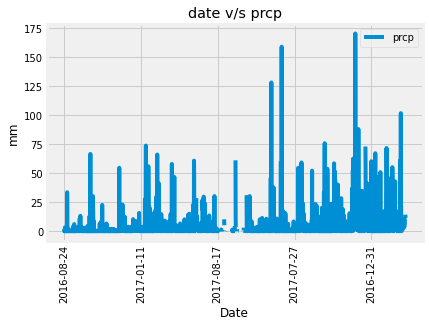

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
latest_date = session.query(func.max(Measurement.date)).first()[0]
latest_date = datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year_date = latest_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation_query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=last_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_precipitation_df = pd.DataFrame(last_year_precipitation_query,columns=['date','prcp'])
last_year_precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
last_year_precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the precipitation based on date 
last_year_precipitation_df.plot()
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("date v/s prcp")
plt.xlabel("Date")
plt.ylabel("mm")


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_precipitation_df.describe()

,prcp
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_station_list = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_station_list



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
#get the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(1).all()[0]["station"]

most_active_station

'USC00519281'

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_summary = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).group_by(Measurement.station).\
    order_by(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).all()

most_active_station_summary

[('USC00519281', 12.2, 29.4, 22.03582251082252)]

Text(0, 0.5, 'temperature')

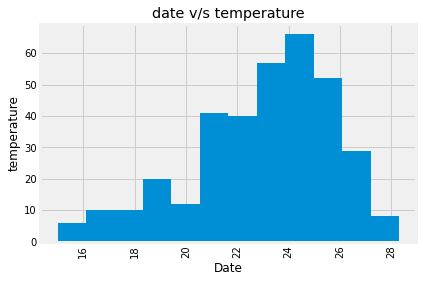

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temp_last_1_year = pd.DataFrame(session.query(Measurement.date, Measurement.tobs,).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date>=last_year_date).\
    order_by(Measurement.tobs).all(),columns=['date','temperature'])

most_active_station_temp_last_1_year.set_index("date",inplace=True)

# Create a Histogram for the temperature for last 12 months for the most active station based on the dates
most_active_station_temp_last_1_year.hist(column='temperature',bins=12)
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("date v/s temperature")
plt.xlabel("Date")
plt.ylabel("temperature")

# Close session

In [24]:
# Close Session
session.close()